# 教師あり NMF による音源分離の実装実験

音源分離したい対象楽器が予め決まっている場合、その楽器による基底周波数成分を予め学習した上で NMF を実行することで、分離性能が高まる。

合成音源の振幅スペクトル行列を$Y$と表すと、既存 NMF は次の分離を行うものである。

$Y \approx HU$

$Y$と$HU$を近似していくことは、$Y$と$HU$の距離を最小化する周波数基底行列$H$およびアクティベーション行列$F$を決定する最適化問題である。

これに対し Semi-supervised NMF は予め学習した基底周波数成分$F$を用いて、次の分離を行うものである。

$Y \approx FG + HU$

    
ここで$F$は所与の値なので、$Y$と$FG + HU$の距離を最小化する周波数基底行列$H$およびアクティベーション行列$U$に加え、教師基底におけるアクティベーション行列$G$を決定する最適化問題である。

この最適化問題における目的関数 (コスト関数) を導出している論文を参照し、実装を試みた。

In [1]:
import numpy as np
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})

# Basic NMF

まずは基本の NMF を、意図した通りに動作するよう実装した。なお距離にはユークリッド距離を用いた。

In [2]:
def NMF(Y, R=3, n_iter=50, init_H=[], init_U=[], verbose=False):
    """
    decompose non-negative matrix to components and activation with NMF
    
    Y ≈　HU
    Y ∈ R (m, n)
    H ∈ R (m, k)
    HU ∈ R (k, n)
    
    parameters
    ---- 
    Y: target matrix to decompose
    R: number of bases to decompose
    n_iter: number for executing objective function to optimize
    init_H: initial value of H matrix. default value is random matrix
    init_U: initial value of U matrix. default value is random matrix
    
    return
    ----
    Array of:
    0: matrix of H
    1: matrix of U
    2: array of cost transition
    """

    eps = np.spacing(1)

    # size of input spectrogram
    M = Y.shape[0]
    N = Y.shape[1]
    
    # initialization
    if len(init_U):
        U = init_U
        R = init_U.shape[0]
    else:
        U = np.random.rand(R,N);

    if len(init_H):
        H = init_H;
        R = init_H.shape[1]
    else:
        H = np.random.rand(M,R)

    # array to save the value of the euclid divergence
    cost = np.zeros(n_iter)

    # computation of Lambda (estimate of Y)
    Lambda = np.dot(H, U)

    # iterative computation
    for i in range(n_iter):

        # compute euclid divergence
        cost[i] = euclid_divergence(Y, Lambda)

        # update H
        H *= np.dot(Y, U.T) / (np.dot(np.dot(H, U), U.T) + eps)
        
        # update U
        U *= np.dot(H.T, Y) / (np.dot(np.dot(H.T, H), U) + eps)
        
        # recomputation of Lambda
        Lambda = np.dot(H, U)

    return [H, U, cost]

def euclid_divergence(Y, Yh):
    d = 1 / 2 * (Y**2 + Yh**2 - 2 * Y * Yh).sum()
    return d

In [3]:
# 動作確認。Y と HU がある程度近似的に見えれば OK

np.random.seed(1)
comps = np.array(((1,0), (0,1), (1,1)))
activs = np.array(((0,0,1,0,1,5,0,7,9,6,5,0), (2,1,0,1,1,2,1,0,0,0,6,0)))
Y = np.dot(comps, activs)

print('original data\n---------------')
print('components:\n', comps)
print('activations:\n', activs)
print('Y:\n', Y)

computed = NMF(Y, R=2)

print('\ndecomposed\n---------------')
print('H:\n', computed[0])
print('U:\n', computed[1])
print('HU:\n', np.dot(computed[0], computed[1]))
print('cost:\n', computed[2])

original data
---------------
components:
 [[1 0]
 [0 1]
 [1 1]]
activations:
 [[0 0 1 0 1 5 0 7 9 6 5 0]
 [2 1 0 1 1 2 1 0 0 0 6 0]]
Y:
 [[ 0  0  1  0  1  5  0  7  9  6  5  0]
 [ 2  1  0  1  1  2  1  0  0  0  6  0]
 [ 2  1  1  1  2  7  1  7  9  6 11  0]]

decomposed
---------------
H:
 [[ 0.17  4.75]
 [ 2.28  0.00]
 [ 2.47  4.65]]
U:
 [[ 0.84  0.42  0.00  0.42  0.44  0.89  0.42  0.07  0.08  0.06  2.64  0.00]
 [ 0.00  0.00  0.21  0.00  0.20  1.03  0.00  1.47  1.89  1.26  0.96  0.00]]
HU:
 [[ 0.14  0.07  1.01  0.07  1.00  5.02  0.07  6.99  8.99  5.99  5.00  0.00]
 [ 1.91  0.96  0.00  0.96  1.00  2.03  0.96  0.16  0.19  0.13  6.02  0.00]
 [ 2.07  1.04  0.99  1.04  2.00  6.97  1.04  7.01  9.00  6.00  10.99  0.00]]
cost:
 [ 260.52  25.89  24.77  24.13  23.55  22.87  21.88  20.40  18.27  15.55
  12.54  9.63  7.11  5.09  3.56  2.46  1.71  1.20  0.87  0.65  0.51  0.41
  0.35  0.30  0.27  0.24  0.22  0.20  0.19  0.18  0.17  0.16  0.15  0.14
  0.13  0.13  0.12  0.12  0.11  0.11  0.10  0.10  0.0

# Semi-supervised NMF

NMF が実装できたら、次は所与の学習済み基底成分を固定化して NMF を行う Semi-supervised NMF を実装する。
Semi-supervised NMF の直感的説明としては [2], [3] がわかりやすい。
また Semi-supervised NMF における最適化問題の目的関数導出は [1] を参考にした。

[1] β-divergence 規範による罰則条件付き教師あり非負値行列因子分解を用いた目的楽器音抽出
https://library.naist.jp/mylimedio/search/book.do?target=local&bibid=59439&lang=ja&charset=utf8&dimode=on

[2] Source Separation Tutorial Mini-Series III: Extensions and Interpretations to Non-Negative Matrix Factorization
https://ccrma.stanford.edu/~njb/teaching/sstutorial/part3.pdf

[3] 基底変形型教師ありNMFによる実楽器信号分離
http://www.slideshare.net/DaichiKitamura/nmf-in-japanese

In [4]:
def SNMF(Y, R=3, n_iter=50, F=[], init_G=[], init_H=[], init_U=[], verbose=False):
    """
    decompose non-negative matrix to components and activation with semi-supervised NMF
    
    Y ≈　FG + HU
    Y ∈ R (m, n)
    F ∈ R (m, x)
    G ∈ R (x, n)
    H ∈ R (m, k)
    U ∈ R (k, n)

    parameters
    ---- 
    Y: target matrix to decompose
    R: number of bases to decompose
    n_iter: number for executing objective function to optimize
    F: matrix as supervised base components
    init_W: initial value of W matrix. default value is random matrix
    init_H: initial value of W matrix. default value is random matrix

    return
    ----
    Array of:
    0: matrix of F
    1: matrix of G
    2: matrix of H
    3: matrix of U
    4: array of cost transition
    """
    
    eps = np.spacing(1)

    # size of input spectrogram
    M = Y.shape[0];
    N = Y.shape[1]; 
    X = F.shape[1]
    
    # initialization
    if len(init_G):
        G = init_G
        X = init_G.shape[1]
    else:
        G = np.random.rand(X, N)
        
    if len(init_U):
        U = init_U
        R = init_U.shape[0]
    else:
        U = np.random.rand(R, N)

    if len(init_H):
        H = init_H;
        R = init_H.shape[1]
    else:
        H = np.random.rand(M, R)

    # array to save the value of the euclid divergence
    cost = np.zeros(n_iter)

    # computation of Lambda (estimate of Y)
    Lambda = np.dot(F, G) + np.dot(H, U)

    # iterative computation
    for it in range(n_iter):

        # compute euclid divergence
        cost[it] = euclid_divergence(Y, Lambda + eps)

        # update of H
        H *= (np.dot(Y, U.T) + eps) / (np.dot(np.dot(H, U) + np.dot(F, G), U.T) + eps)
        # print(it, 'H', euclid_divergence(Y + eps, np.dot(H, U) + np.dot(F, G) + eps))

        # update of U
        U *= (np.dot(H.T, Y) + eps) / (np.dot(H.T, np.dot(H, U) + np.dot(F, G)) + eps)
        # print(it, 'U', euclid_divergence(Y + eps, np.dot(H, U) + np.dot(F, G) + eps))
        
        # update of G
        G *= (np.dot(F.T, Y) + eps)[np.arange(G.shape[0])] / (np.dot(F.T, np.dot(H, U) + np.dot(F, G)) + eps)
        # print(it, 'G', euclid_divergence(Y + eps, np.dot(H, U) + np.dot(F, G) + eps))
        
        # recomputation of Lambda (estimate of V)
        Lambda = np.dot(H, U) + np.dot(F, G)
        
    return [F, G, H, U, cost]

def euclid_divergence(V, Vh):
    d = 1 / 2 * (V**2 + Vh**2 - 2 * V * Vh).sum()
    return d

In [5]:
# 動作確認。Y と FG + HU がある程度近似的に見えれば OK
# このパラメータでは近似度がまだ低く、コスト関数の値をみてもまだまだ収束していない感がある
# SNMF のパラメータ引数 n_iter を大きくすると計算量が増えるが、近似度が高くなる。

np.random.seed(1)
comps = np.array(((1,0), (0,1), (1,1)))
activs = np.array(((0,0,1,0,1,5,0,7,9,6,5,0), (2,1,0,1,1,2,1,0,0,0,6,0)))
Y = np.dot(comps, activs)

print('original data\n---------------')
print('components:\n', comps)
print('activations:\n', activs)
print('Y:\n', Y)

computed = SNMF(Y, F=np.array(((1,0,1),)).T, R=2)

print('\ndecomposed\n---------------')
print('F:\n', computed[0])
print('G:\n', computed[1])
print('H:\n', computed[2])
print('U:\n', computed[3])
print('FG + HU:\n', np.dot(computed[0], computed[1]) + np.dot(computed[2], computed[3]))
print('cost:\n', computed[4])

original data
---------------
components:
 [[1 0]
 [0 1]
 [1 1]]
activations:
 [[0 0 1 0 1 5 0 7 9 6 5 0]
 [2 1 0 1 1 2 1 0 0 0 6 0]]
Y:
 [[ 0  0  1  0  1  5  0  7  9  6  5  0]
 [ 2  1  0  1  1  2  1  0  0  0  6  0]
 [ 2  1  1  1  2  7  1  7  9  6 11  0]]

decomposed
---------------
F:
 [[1]
 [0]
 [1]]
G:
 [[ 0.00  0.00  0.00  0.00  0.05  0.12  0.00  1.08  0.85  0.86  0.20  0.00]]
H:
 [[ 3.37  0.71]
 [ 0.00  1.84]
 [ 3.19  2.60]]
U:
 [[ 0.00  0.00  0.29  0.00  0.16  1.22  0.00  1.72  2.37  1.49  0.67  0.00]
 [ 0.83  0.42  0.03  0.42  0.55  1.13  0.42  0.17  0.22  0.14  3.33  0.00]]
FG + HU:
 [[ 0.59  0.30  1.00  0.30  0.98  5.04  0.30  7.00  9.01  6.01  4.84  0.00]
 [ 1.53  0.77  0.05  0.77  1.02  2.08  0.77  0.31  0.40  0.25  6.12  0.00]
 [ 2.17  1.08  1.00  1.08  2.00  6.95  1.08  6.99  8.98  5.99  11.01  0.00]]
cost:
 [ 212.61  27.14  20.97  19.82  18.41  16.70  14.74  12.61  10.49  8.57
  6.99  5.79  4.90  4.26  3.78  3.41  3.11  2.86  2.64  2.45  2.29  2.14
  2.01  1.89  1.79  1.6

## Exercise with wave file

ドラム音のみの音声ファイルと、ドラム音+ベース音が合成された音声ファイルがある。

Semi-supervised NMF を用いてこれらの音源を分離する。

1. ドラム音のみの波形を短時間フーリエ変換して振幅スペクトルを得る。
2. ドラム音の振幅スペクトルを基本 NMF によって分解し、基底成分を得る。これを学習済み基底成分と見立てる。
3. ドラム音+ベース音の波形を短時間フーリエ変換して振幅スペクトルを得る。
4. ドラム音+ベース音の振幅スペクトルを、2 で得た学習済み基底成分とともに Semi-supervised NMF によって分解する。
5. 分解した基底成分とアクティベーション行列から、ドラム音のみの振幅スペクトルおよびドラム音を除いた振幅スペクトルを再合する
6. ドラム音のみの振幅スペクトルおよびドラム音を除いた振幅スペクトルを逆短時間フーリエ変換して波形データを再合成する。

In [6]:
import librosa
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from IPython.display import display, Audio
%matplotlib inline

ソース音源: ドラム音+ベース音


ソース音源: ドラム音


ソース音源: ベース音 (後の計算に使用しないが参考のため)


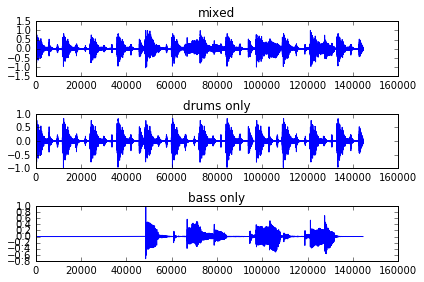

In [7]:
# load wav

y_db, sr_db = librosa.load('data/drums+bass.wav')
y_d, sr_d = librosa.load('data/drums.wav')
y_b, sr_b = librosa.load('data/bass.wav')

plt.subplot(311)
plt.title('mixed')
plt.plot(y_db)
plt.subplot(312)
plt.title('drums only')
plt.plot(y_d)
plt.subplot(313)
plt.title('bass only')
plt.plot(y_b)
plt.tight_layout()

print('ソース音源: ドラム音+ベース音')
display(Audio(y_db, rate=sr_db))
print('ソース音源: ドラム音')
display(Audio(y_d, rate=sr_d))
print('ソース音源: ベース音 (後の計算に使用しないが参考のため)')
display(Audio(y_b, rate=sr_b))

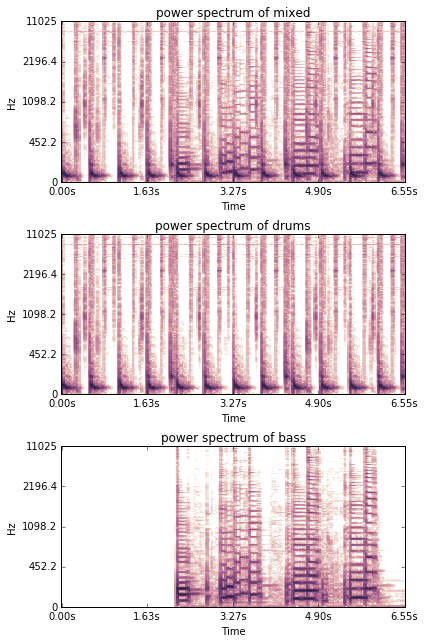

In [8]:
# STFT

S_db = librosa.stft(y_db)
S_d = librosa.stft(y_d)
S_b = librosa.stft(y_b)

P_db = librosa.logamplitude(np.abs(S_db) ** 2, ref_power=np.max)
P_d = librosa.logamplitude(np.abs(S_d) ** 2, ref_power=np.max)
P_b = librosa.logamplitude(np.abs(S_b) ** 2, ref_power=np.max)

plt.figure(figsize=(6, 9))
plt.subplot(311)
plt.title('power spectrum of mixed')
librosa.display.specshow(P_db, y_axis='log', x_axis='time', sr=sr_db)
plt.subplot(312)
plt.title('power spectrum of drums')
librosa.display.specshow(P_d, y_axis='log', x_axis='time', sr=sr_d)
plt.subplot(313)
plt.title('power spectrum of bass')
librosa.display.specshow(P_b, y_axis='log', x_axis='time', sr=sr_b)
plt.tight_layout()

In [9]:
# learn drums as base

# ドラム音学習で分解する基底数
R_d = 50

# ドラム音学習で行う反復計算回数
n_iter=300

nmf_d = NMF(np.abs(S_d), R=R_d, n_iter=n_iter)
base = nmf_d[0]

In [10]:
# decompose by SNMF

# Semi-supervised NMF で分解する基底数
R = 20

# Semi-supervised NMF で行う反復計算回数
n_iter = 50

%time snmf_db_d = SNMF(np.abs(S_db), F=base, R=R, n_iter=n_iter)

CPU times: user 8.47 s, sys: 779 ms, total: 9.25 s
Wall time: 7.83 s


In [11]:
# confirm each {F / G / H / U} 's size and divergence

for i in range(5):
    print(i, np.shape(snmf_db_d[i]))
print('cost', snmf_db_d[4])    

0 (1025, 50)
1 (50, 283)
2 (1025, 20)
3 (20, 283)
4 (50,)
cost [ 6599381.78  1016277.74  565297.00  438849.50  377005.84  335127.87
  299534.74  264070.03  228375.76  194823.67  165832.54  142492.59
  124297.17  110536.91  100115.90  91914.22  85153.13  79319.44  74094.89
  69315.50  64940.40  61005.69  57547.36  54554.80  51980.45  49764.97
  47849.73  46180.81  44712.00  43406.32  42235.22  41176.89  40214.53
  39334.56  38525.17  37776.25  37080.02  36431.21  35826.35  35262.49
  34736.28  34243.91  33781.55  33345.72  32933.52  32542.56  32170.89
  31816.89  31479.24  31156.83]


ドラム音のみの音源から学習した基底を用いて、合成音源からドラム音のみを再合成したもの


ドラム音のみの音源から学習した基底を用いて、合成音源からドラム音を除いて再合成したもの


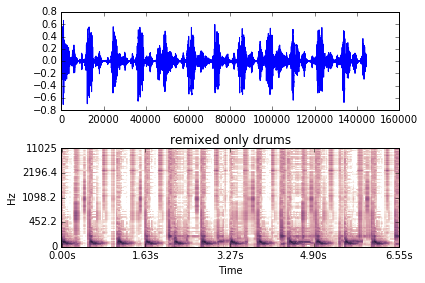

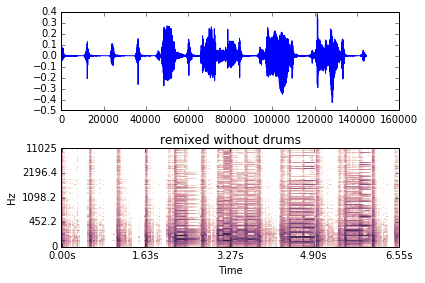

In [12]:
# remix with separated matrix by SNMF

remixed_only_d = librosa.istft((np.dot(snmf_db_d[0], snmf_db_d[1]) * (np.cos(np.angle(S_db) + 1j * np.sin(np.angle(S_db))))))
remixed_without_d = librosa.istft(np.dot(snmf_db_d[2], snmf_db_d[3]) * (np.cos(np.angle(S_db) + 1j * np.sin(np.angle(S_db)))))
print('ドラム音のみの音源から学習した基底を用いて、合成音源からドラム音のみを再合成したもの')
display(Audio(remixed_only_d, rate=sr_db))
print('ドラム音のみの音源から学習した基底を用いて、合成音源からドラム音を除いて再合成したもの')
display(Audio(remixed_without_d, rate=sr_db))

plt.figure()
plt.subplot(211)
plt.plot(remixed_only_d)
plt.subplot(212)
plt.title('remixed only drums')
librosa.display.specshow(librosa.logamplitude(np.abs(np.dot(snmf_db_d[0], snmf_db_d[1])) ** 2, ref_power=np.max), y_axis='log', x_axis='time', sr=sr_db)
plt.tight_layout()

plt.figure()
plt.subplot(211)
plt.plot(remixed_without_d)
plt.subplot(212)
plt.title('remixed without drums')
librosa.display.specshow(librosa.logamplitude(np.abs(np.dot(snmf_db_d[2], snmf_db_d[3])) ** 2, ref_power=np.max), y_axis='log', x_axis='time', sr=sr_db)
plt.tight_layout()

# 考察

NMF は反復的な計算が必要であり精度を高めるためにはそれなりの実行時間が必要になる。
リアルタイム適用を考慮すると、反復計算の回数や、基底数などを調整する必要がある。

基底数については、少ない基底数でもとの振幅スペクトルを復元できれば、分離性能および計算量のどちらに対しても理想的であるが、実際のところ、基底数が少なすぎると復元される音源の品質が悪くなるため、適切な値を見つけるためには試行錯誤が必要である。

学習する基底数と Semi-supervised NMF で求める基底数の比率を変えると、分離結果も大きく変化する。学習する基底数のほうが大きいと、分離されにくく、逆に小さいと、分散されやすい傾向があるように感じられる。